# Identificação do Cliente de maior valor

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dez 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.1. Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import inflection

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m## 0.1. Helper Functions

from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
# Carregando dados
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0. Descrição dos Dados

In [5]:
df1 = df_raw.copy()

## 1.1. Renomear Colunas

In [6]:
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, df_raw.columns))

df1.columns = cols_new

df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2. Dimensões dos dados

In [7]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de Atributos: {df1.shape[1]}')

Número de linhas: 541909
Número de Atributos: 8


## 1.3. Tipo dos Dados

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
df1 = df1.dropna( subset=['description', 'customer_id'])
print('Dados Removidos: {:.2f}'.format( 1 - (df1.shape[0] / df_raw.shape[0] )))

Dados Removidos: 0.25


## 1.6. Mudança de DataType

In [11]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [12]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

In [13]:
df1['customer_id'] = df1['customer_id'].astype( int )

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7. Estatística Descritiva

Vou deixar para fazer no proximo ciclo, neste vou seguir desta maneira.

# 2.0. Feature Engineering

In [15]:
df2 = df1.copy()

## 2.1. Criação de features

In [16]:
df_ref = df2[['customer_id']].drop_duplicates( ignore_index=True )
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [17]:
# Gross Revenue - Faturamento
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

In [18]:
df_ref.head()

,customer_id,gross_revenue
0,17850,5288.63
1,13047,3079.10
2,12583,7187.34
3,13748,948.25
4,15100,635.10


In [19]:
# Recência - Últimno dia com compra
df_recency = df2[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')

In [20]:
# Frequência
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')

In [21]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


# 3.0. Filtragem de Variáveis

In [23]:
df3 = df_ref.copy()

# 4.0. Análise Exploratória dos Dados - EDA

In [24]:
df4 = df3.copy()

## 4.1. Análise Univariada

## 4.2. Análise Univariada

## 4.2. Análise Multivariada

# 5.0. Preparação dos Dados

In [25]:
df5 = df4.copy()

# 6.0. Seleção de Features

In [26]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning

In [40]:
X = df6.drop( columns=['customer_id'] )

In [41]:
clusters = [2, 3, 4, 5, 6]

## 7.1. Within-Cluster Sum of Square (WSS)

Text(0.5, 1.0, 'WSS vs K')

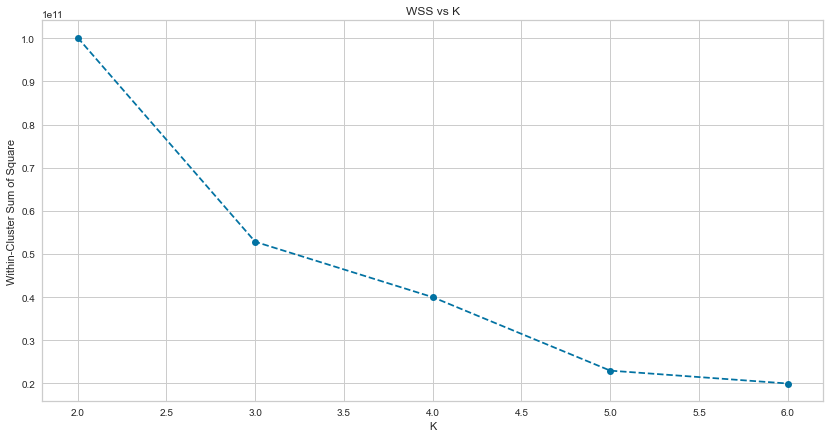

In [49]:
wss = []

for k in clusters:
    # Model Definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # model taining
    kmeans.fit( X )
    
    # Validation
    wss.append( kmeans.inertia_ )
    
# plot wss

plt.figure(figsize=(14,7))
plt.plot( clusters, wss, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K')
plt.ylabel( 'Within-Cluster Sum of Square' )
plt.title( 'WSS vs K')

## 7.2. Silhouette Score

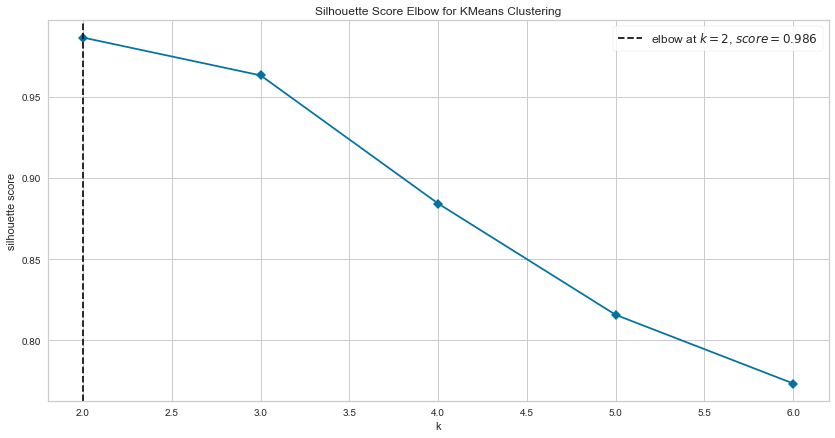

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [52]:
plt.figure(figsize=(14,7))
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit( X )
kmeans.show()

# 8.0. Modelagem de Machine Learning

# 9.0. Análise dos clusters

# 10.0. Deploy Modelo em Produção